In [1]:
import pandas as pd
import numpy as np
import gzip
import json
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
filename = "../data/dataset0.json.gz"

In [17]:
FEATURE_NAMES = ['dwell_-1','std_-1','mean_-1',
                 'dwell_0','std_0','mean_0',
                 'dwell_+1','std_+1','mean_+1']

In [3]:
def flatten_deep_data_ultra_fast(file_path, estimated_rows=11000000):
    """
    Ultra-optimized version with multiple improvements:
    - Batch processing to reduce index checks
    - Better memory allocation strategy
    - Faster resize logic
    - Direct array assignment
    
    Expected speedup: 2-3x
    """
    BATCH_SIZE = 10000
    GROWTH_FACTOR = 1.5
    
    # Pre-allocate arrays
    capacity = estimated_rows
    transcript_ids = np.empty(capacity, dtype=object)
    positions = np.empty(capacity, dtype=np.int32)
    seq = np.empty(capacity, dtype=object)
    feature_arrays = [np.empty(capacity, dtype=np.float32) for _ in range(9)]
    
    idx = 0
    batch_start = 0
    
    # Temporary batch storage
    batch_transcript_ids = []
    batch_positions = []
    batch_seq = []
    batch_features = [[] for _ in range(9)]
    
    def flush_batch():
        """Flush batch to main arrays"""
        nonlocal idx, batch_start, capacity
        
        batch_size = len(batch_transcript_ids)
        if batch_size == 0:
            return
        
        # Resize if needed
        while idx + batch_size > capacity:
            new_capacity = int(capacity * GROWTH_FACTOR)
            transcript_ids.resize(new_capacity, refcheck=False)
            positions.resize(new_capacity, refcheck=False)
            seq.resize(new_capacity, refcheck=False)
            for i in range(9):
                feature_arrays[i].resize(new_capacity, refcheck=False)
            capacity = new_capacity
        
        # Bulk assignment
        transcript_ids[idx:idx+batch_size] = batch_transcript_ids
        positions[idx:idx+batch_size] = batch_positions
        seq[idx:idx+batch_size] = batch_seq
        for i in range(9):
            feature_arrays[i][idx:idx+batch_size] = batch_features[i]
        
        idx += batch_size
        
        # Clear batch
        batch_transcript_ids.clear()
        batch_positions.clear()
        batch_seq.clear()
        for lst in batch_features:
            lst.clear()
    
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            for transcript_id, positions_dict in data.items():
                for transcript_position, sequences in positions_dict.items():
                    pos_int = int(transcript_position)
                    for sequence, feature_list in sequences.items():
                        for features in feature_list:
                            # Add to batch
                            batch_transcript_ids.append(transcript_id)
                            batch_positions.append(pos_int)
                            batch_seq.append(sequence)
                            for i, val in enumerate(features):
                                batch_features[i].append(val)
                            
                            # Flush when batch is full
                            if len(batch_transcript_ids) >= BATCH_SIZE:
                                flush_batch()
                                
                                if idx % 100000 == 0:
                                    print(f"Processed {idx:,} rows...", end='\r')
    
    # Flush remaining batch
    flush_batch()
    
    print(f"\nCreating DataFrame with {idx:,} rows...")
    
    # Trim and create DataFrame
    df = pd.DataFrame({
        'transcript_id': transcript_ids[:idx],
        'transcript_position': positions[:idx],
        'sequence': seq[:idx],
        'dwell_-1': feature_arrays[0][:idx],
        'std_-1': feature_arrays[1][:idx],
        'mean_-1': feature_arrays[2][:idx],
        'dwell_0': feature_arrays[3][:idx],
        'std_0': feature_arrays[4][:idx],
        'mean_0': feature_arrays[5][:idx],
        'dwell_+1': feature_arrays[6][:idx],
        'std_+1': feature_arrays[7][:idx],
        'mean_+1': feature_arrays[8][:idx],
    })
    
    return df

In [4]:
# Execute the flattening process
flat_read_df = flatten_deep_data_ultra_fast(filename)

print("\n--- Flattened Read-Level DataFrame ---")
print(f"Shape: {flat_read_df.shape} (Each row is one Nanopore read)")
print(flat_read_df.head())
# column names of the dataframe
#print(flat_read_df.columns.tolist())
# 1 row of the dataframe
#print(flat_read_df.iloc[0])

Processed 11,000,000 rows...
Creating DataFrame with 11,027,106 rows...

--- Flattened Read-Level DataFrame ---
Shape: (11027106, 12) (Each row is one Nanopore read)
     transcript_id  transcript_position sequence  dwell_-1  std_-1  mean_-1  \
0  ENST00000000233                  244  AAGACCA   0.00299    2.06    125.0   
1  ENST00000000233                  244  AAGACCA   0.00631    2.53    125.0   
2  ENST00000000233                  244  AAGACCA   0.00465    3.92    109.0   
3  ENST00000000233                  244  AAGACCA   0.00398    2.06    125.0   
4  ENST00000000233                  244  AAGACCA   0.00664    2.92    120.0   

   dwell_0  std_0  mean_0  dwell_+1  std_+1    mean_+1  
0  0.01770  10.40   122.0   0.00930   10.90  84.099998  
1  0.00844   4.67   126.0   0.01030    6.30  80.900002  
2  0.01360  12.00   124.0   0.00498    2.13  79.599998  
3  0.00830   5.01   130.0   0.00498    3.78  80.400002  
4  0.00266   3.94   129.0   0.01300    7.15  82.199997  


In [5]:
labels = "../data/data.info.labelled"

In [6]:
def load_and_merge_labels_csv(feature_matrix, label_file_path='data.info'):
    """
    Loads a CSV label file with a header and merges it with the site-level 
    feature matrix using a newly created site_id.
    """
    
    # 1. Load the CSV file. Pandas correctly assumes header=0 and sep=',' by default.
    label_df = pd.read_csv(label_file_path)
    
    # 2. Create the 'site_id' column in the label DataFrame to match the features
    label_df['site_id'] = label_df['transcript_id'] + '@' + label_df['transcript_position'].astype(str)
    feature_matrix['site_id'] = feature_matrix['transcript_id'] + '@' + feature_matrix['transcript_position'].astype(str)
    # 3. Select the essential columns for merging
    label_subset = label_df[['site_id', 'gene_id', 'label']].copy()
    
    # 4. Merge Features and Labels on 'site_id'
    final_dataset = pd.merge(
        feature_matrix, 
        label_subset, 
        on='site_id', 
        how='inner' 
    )
    
    print(f"✅ Successfully created the final training dataset! Shape: {final_dataset.shape}")
    print("\nTarget Label Distribution (crucial for class imbalance analysis):")
    print(final_dataset['label'].value_counts(normalize=True))
    
    return final_dataset

# Assuming 'feature_matrix' is the aggregated result from the previous step:
# final_dataset = load_and_merge_labels_csv(feature_matrix, 'data.info')

In [7]:
labelled_df = load_and_merge_labels_csv(flat_read_df, labels)
print("\n--- Labelled DataFrame ---")
print(f"Shape: {labelled_df.shape} (Each row is one Nanopore read)")
#print(labelled_df.head())
print(labelled_df.shape)


✅ Successfully created the final training dataset! Shape: (11027106, 15)

Target Label Distribution (crucial for class imbalance analysis):
label
0    0.954696
1    0.045304
Name: proportion, dtype: float64

--- Labelled DataFrame ---
Shape: (11027106, 15) (Each row is one Nanopore read)
(11027106, 15)


In [8]:
import pandas as pd
import numpy as np
from scipy import stats
import time


In [28]:
def aggregate_to_site_level(df, features_to_aggregate):
    """
    Groups the read-level DataFrame by site, calculates features
    """
    
    # 1. Define aggregation functions
    agg_funcs = {}
    for feature in features_to_aggregate:
        agg_funcs[feature] = ['mean', 'std']  # Keeps std dev

    # 2. Perform the aggregation
    site_features_grouped = df.groupby(['transcript_id', 'transcript_position', 'sequence', 'label', 'gene_id']).agg(agg_funcs)
    
    # 3. Flatten the multi-level column names for a clean DataFrame
    new_columns = []
    for col in site_features_grouped.columns:
            new_columns.append(f'{col[0]}_{col[1]}')
            
    site_features_grouped.columns = new_columns
    
    # 4. Prepare final feature matrix with site_id
    feature_matrix = site_features_grouped.reset_index()
    feature_matrix['site_id'] = feature_matrix['transcript_id'] + '@' + feature_matrix['transcript_position'].astype(str)
    
    print(f"Aggregation complete. Feature matrix shape: {feature_matrix.shape}")
    
    return feature_matrix

In [29]:
agg_df = aggregate_to_site_level(labelled_df, FEATURE_NAMES)

print("\n--- Aggregated DataFrame ---")
print(f"Shape: {agg_df.shape} (Each row is one Nanopore read)")
#print(summarized_df.head())
# column names of the dataframe
print(agg_df.columns.tolist())
# 1 row of the dataframe

Aggregation complete. Feature matrix shape: (121838, 24)
New column 'unique_read_ids_set' contains the unique list of read IDs per site.

--- Aggregated DataFrame ---
Shape: (121838, 24) (Each row is one Nanopore read)
['transcript_id', 'transcript_position', 'sequence', 'label', 'gene_id', 'dwell_-1_mean', 'dwell_-1_std', 'std_-1_mean', 'std_-1_std', 'mean_-1_mean', 'mean_-1_std', 'dwell_0_mean', 'dwell_0_std', 'std_0_mean', 'std_0_std', 'mean_0_mean', 'mean_0_std', 'dwell_+1_mean', 'dwell_+1_std', 'std_+1_mean', 'std_+1_std', 'mean_+1_mean', 'mean_+1_std', 'site_id']


In [30]:
def encode_sequence_to_columns(df, seq_column='sequence'):
    """
    One-hot encode DNA sequences with DRACH motif awareness.
    Position 0 (A) and position 1 (C) are constant, so only encode:
    positions -3, -2, -1, 2, 3
    
    Args:
        df: DataFrame containing sequences
        seq_column: Name of the column containing 7-mer sequences
    
    Returns:
        DataFrame with original data plus 20 boolean one-hot encoded columns
    """
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    bases = ['A', 'C', 'G', 'T']
    
    # Position mapping: array index -> position label
    # Index: 0,  1,  2, 3, 4, 5, 6
    # Pos:  -3, -2, -1, 0, 1, 2, 3
    positions_to_encode = [
        (-3, 0),  # position -3 is at index 0
        (-2, 1),  # position -2 is at index 1
        (-1, 2),  # position -1 is at index 2
        # Skip position 0 (index 3) - always A
        # Skip position 1 (index 4) - always C
        (2, 5),   # position 2 is at index 5
        (3, 6),   # position 3 is at index 6
    ]
    
    # Create column names for variable positions only
    col_names = [f'pos{pos}_{base}' for pos, _ in positions_to_encode for base in bases]
    
    # Initialize array (5 positions × 4 bases = 20 columns)
    encoded = np.zeros((len(df), len(positions_to_encode) * 4), dtype=bool)
    
    # Encode each sequence
    for row_idx, seq in enumerate(df[seq_column]):
        for col_offset, (pos_label, seq_idx) in enumerate(positions_to_encode):
            base = seq[seq_idx].upper()
            if base in mapping:
                col_idx = col_offset * 4 + mapping[base]
                encoded[row_idx, col_idx] = True
    
    # Create DataFrame with encoded columns
    encoded_df = pd.DataFrame(encoded, columns=col_names, index=df.index)
    
    # Concatenate with original dataframe
    result = pd.concat([df, encoded_df], axis=1)
    
    return result

In [31]:
full_df = encode_sequence_to_columns(agg_df)
full_df.head()

,transcript_id,transcript_position,sequence,label,gene_id,dwell_-1_mean,dwell_-1_std,std_-1_mean,std_-1_std,mean_-1_mean,...,pos-1_G,pos-1_T,pos2_A,pos2_C,pos2_G,pos2_T,pos3_A,pos3_C,pos3_G,pos3_T
0,ENST00000000233,244,AAGACCA,0,ENSG00000004059,0.008264,0.005399,4.223784,1.848027,123.702705,...,True,False,False,True,False,False,True,False,False,False
1,ENST00000000233,261,CAAACTG,0,ENSG00000004059,0.006609,0.003599,3.216424,1.694099,109.681389,...,False,False,False,False,False,True,False,False,True,False
2,ENST00000000233,316,GAAACAG,0,ENSG00000004059,0.007570,0.004456,2.940541,1.314661,105.475677,...,False,False,True,False,False,False,False,False,True,False
3,ENST00000000233,332,AGAACAT,0,ENSG00000004059,0.010620,0.006136,6.476350,2.465488,129.354996,...,False,False,True,False,False,False,False,False,False,True
4,ENST00000000233,368,AGGACAA,0,ENSG00000004059,0.010701,0.007169,6.415051,2.750181,117.924240,...,True,False,True,False,False,False,True,False,False,False


In [32]:
from sklearn.model_selection import train_test_split

In [37]:
# Assuming 'full_df' is your DataFrame after feature aggregation and label merging.
# It MUST contain the 'gene_id' and 'label' columns.
label_cols = ['sequence', 'site_id','gene_id','label', 'transcript_id', 'transcript_position']

# 1. Separate features (X) and target (y)
# Drop all non-feature columns except 'gene_id' (needed for splitting)
gene_ids_col = full_df['gene_id'] # Keep this separate for splitting
y = full_df['label']
X = full_df.drop(label_cols, axis=1)


# 2. Split the unique gene IDs (80% for training, 20% for testing)
unique_genes = gene_ids_col.unique()

# Split the list of unique gene IDs
train_genes, test_genes = train_test_split(
    unique_genes, 
    test_size=0.2, 
    random_state=42 # Use a fixed seed for reproducible results!
)

# 3. Create the final train and test indices based on the gene split
# This avoids data leakage by ensuring all sites from a test gene are in the test set.
train_indices = full_df['gene_id'].isin(train_genes)
test_indices = full_df['gene_id'].isin(test_genes)


# 4. Apply indices to features (X) and target (y)
X_train = X[train_indices]
X_test = X[test_indices]
y_train = y[train_indices]
y_test = y[test_indices]

print("--- Gene-Level Split Results ---")
print(f"Total Unique Genes: {len(unique_genes)}")
print(f"Train Genes: {len(train_genes)}, Test Genes: {len(test_genes)}")
print(f"X_train shape: {X_train.shape} (Sites for training)")
print(f"X_test shape: {X_test.shape} (Pristine sites for final evaluation)")

--- Gene-Level Split Results ---
Total Unique Genes: 3852
Train Genes: 3081, Test Genes: 771
X_train shape: (96821, 38) (Sites for training)
X_test shape: (25017, 38) (Pristine sites for final evaluation)


In [38]:
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
import pandas as pd

In [39]:

# Instantiate SMOTE. We target a 1:1 ratio (fully balanced).
# You can experiment with different ratios (e.g., 0.5 for 2:1)
smote = SMOTE(
    sampling_strategy='auto', 
    random_state=42,
)

print("\n--- Applying SMOTE to Training Data ---")

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Calculate and display the change in class balance
print(f"Original Training Class Count (Label 1): {sum(y_train == 1):,}")
print(f"Resampled Training Class Count (Label 1): {sum(y_train_resampled == 1):,}")
print(f"X_train_resampled shape: {X_train_resampled.shape} (Balanced training data)")

# Check the new distribution
print("\nNew Training Label Distribution:")
print(y_train_resampled.value_counts())


--- Applying SMOTE to Training Data ---
Original Training Class Count (Label 1): 4,421
Resampled Training Class Count (Label 1): 92,400
X_train_resampled shape: (184800, 38) (Balanced training data)

New Training Label Distribution:
label
0    92400
1    92400
Name: count, dtype: int64


In [40]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import time

In [41]:
def evaluate_classifier(model, X_train, y_train, X_test, y_test, model_name):
    """Trains a model and evaluates its performance on the test set."""
    
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] # Probability for positive class (label=1)
    
    # Calculate requested metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    
    # Calculate a project-critical metric (ROC AUC)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    # Print results
    print(f"\n--- {model_name} Results ---")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f} (Accuracy of positive predictions)")
    print(f"Recall: {recall:.4f} (Ability to find all positive samples)")
    print(f"ROC AUC: {roc_auc:.4f} (Overall separation power)")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

    return {
        'Model': model_name, 
        'Accuracy': accuracy, 
        'Precision': precision, 
        'Recall': recall, 
        'ROC AUC': roc_auc
    }

In [42]:
# --------------------------------------------------------------------------------------
# 1. Random Forest Classifier
# --------------------------------------------------------------------------------------

rf_model = RandomForestClassifier(
    n_estimators=200,           
    max_depth=10,               # Reduced from 15 to prevent overfitting
    min_samples_split=50,       # Increased from 15 (more regularization)
    min_samples_leaf=20,        # Increased from 5 (more regularization)
    max_features='sqrt',        # Limit features per split (reduces variance)
    min_impurity_decrease=0.001, 
    max_samples=0.8,            
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)


In [43]:
# --------------------------------------------------------------------------------------
# 2. XGBoost Classifier
# --------------------------------------------------------------------------------------

import xgboost as xgb

# XGBoost with regularization to prevent overfitting
xgb_model = xgb.XGBClassifier(
    n_estimators=200,              # Number of boosting rounds
    max_depth=6,                   # Shallower trees than RF (typical for XGBoost)
    learning_rate=0.05,            # Lower learning rate for better generalization
    subsample=0.8,                 # Use 80% of samples (similar to RF max_samples)
    colsample_bytree=0.8,          # Use 80% of features per tree
    colsample_bylevel=0.8,         # Feature sampling per level
    min_child_weight=10,           # Minimum sum of instance weight in a child (like min_samples_leaf)
    gamma=0.1,                     # Minimum loss reduction for split (regularization)
    reg_alpha=0.1,                 # L1 regularization
    reg_lambda=1.0,                # L2 regularization
    scale_pos_weight=None,         # Will calculate from data for imbalance
    random_state=42,
    n_jobs=-1,
    tree_method='hist',            # Faster histogram-based method
    eval_metric='logloss'          # Evaluation metric
)

In [44]:
# --------------------------------------------------------------------------------------
# 3. LightGBM - Faster than XGBoost, often similar performance
# --------------------------------------------------------------------------------------

import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    num_leaves=31,                 # LightGBM uses leaf-wise growth
    subsample=0.8,                 # Row sampling
    colsample_bytree=0.8,          # Column sampling
    min_child_samples=20,          # Like min_samples_leaf
    min_split_gain=0.1,            # Like min_impurity_decrease
    reg_alpha=0.1,                 # L1 regularization
    reg_lambda=1.0,                # L2 regularization
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

In [45]:
# --------------------------------------------------------------------------------------
# 8. Voting Ensemble - Combine multiple models
# --------------------------------------------------------------------------------------

from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('lgb', lgb_model)
    ],
    voting='soft',  # Use probability averaging
    n_jobs=-1
)

In [46]:
ens_results = evaluate_classifier(
    ensemble_model, 
    X_train_resampled, y_train_resampled, 
    X_test, y_test, 
    "Ensemble Model"
)


--- Ensemble Model Results ---
Training Time: 60.10 seconds
Accuracy: 0.9004
Precision: 0.2676 (Accuracy of positive predictions)
Recall: 0.7846 (Ability to find all positive samples)
ROC AUC: 0.9232 (Overall separation power)
Confusion Matrix:
[[21699  2264]
 [  227   827]]


Text(0.5, 1.0, 'Ensemble model ROC AUC Curve')

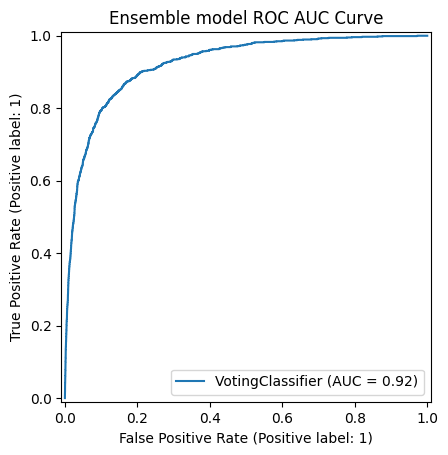

In [47]:
# plot ROC AUC curve for rf_model
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(ensemble_model, X_test, y_test)
plt.title('Ensemble model ROC AUC Curve')

Text(0.5, 1.0, 'Ensemble model PR AUC Curve')

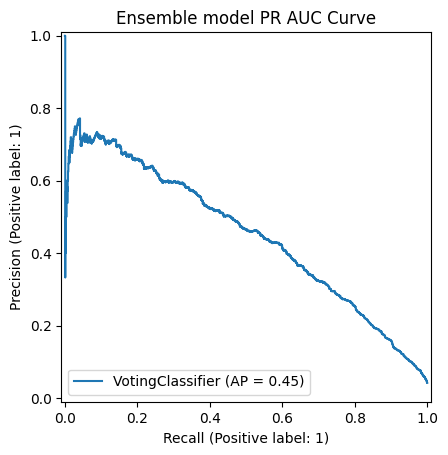

In [48]:
# plot PR AUC curve for rf_model
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(ensemble_model, X_test, y_test)
plt.title('Ensemble model PR AUC Curve')

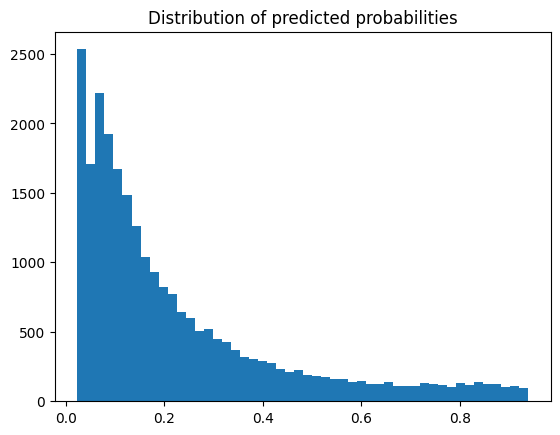

In [49]:
import matplotlib.pyplot as plt
y_pred_proba = ensemble_model.predict_proba(X_test)[:, 1]
plt.hist(y_pred_proba, bins=50)
plt.title("Distribution of predicted probabilities")
plt.show()

In [50]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve, GroupKFold

/home/ubuntu/miniconda/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


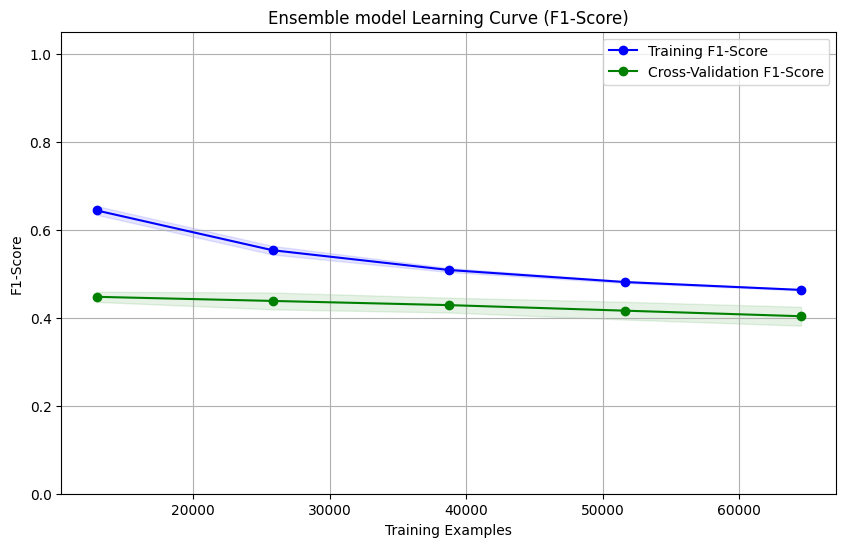

In [51]:
# 1. Define the SMOTE + Classifier Pipeline
#    SMOTE will only be applied to the data within each CV training fold.
smote_rf_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', ensemble_model)
])

# 2. Run learning_curve using the Pipeline
#    NOTE: Use the ORIGINAL, UNSAMPLED training data here (X_train, y_train),
#          NOT the already resampled data (X_train_resampled).
group_cv = GroupKFold(n_splits=3)

# 4. Use learning_curve with grouped CV
train_sizes, train_scores, test_scores = learning_curve(
    estimator=smote_rf_pipeline,
    X=X_train,
    y=y_train,
    groups=full_df[train_indices]["gene_id"],  # Pass gene IDs as groups
    train_sizes=[0.2, 0.4, 0.6, 0.8, 1.0],
    cv=group_cv,  # Use GroupKFold instead of integer
    scoring="f1",
    n_jobs=-1,
    random_state=42
)

# 3. Calculate mean and standard deviation for the scores (same as before)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# 4. Plot the Learning Curve
plt.figure(figsize=(10, 6))
plt.title("Ensemble model Learning Curve (F1-Score)")
plt.xlabel("Training Examples")
plt.ylabel("F1-Score") # Corrected Y-axis label
plt.grid(True)

# Plot training score
plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training F1-Score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="blue")

# Plot cross-validation score
plt.plot(train_sizes, test_scores_mean, 'o-', color="green", label="Cross-Validation F1-Score")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="green")

plt.legend(loc="best")
plt.ylim([0.0, 1.05])
plt.show()